In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as sch
import warnings
warnings.filterwarnings('ignore')

In [39]:
data = pd.read_csv('gpu_specs_v6.csv')
data

,manufacturer,productName,releaseYear,memSize,memBusWidth,gpuClock,memClock,unifiedShader,tmu,rop,pixelShader,vertexShader,igp,bus,memType,gpuChip
0,NVIDIA,GeForce RTX 4050,2023.0,8.000,128.0,1925,2250.0,3840.0,120,48,NaN,NaN,No,PCIe 4.0 x16,GDDR6,AD106
1,Intel,Arc A350M,2022.0,4.000,64.0,300,1500.0,768.0,48,24,NaN,NaN,No,PCIe 4.0 x8,GDDR6,DG2-128
2,Intel,Arc A370M,2022.0,4.000,64.0,300,1500.0,1024.0,64,32,NaN,NaN,No,PCIe 4.0 x8,GDDR6,DG2-128
3,Intel,Arc A380,2022.0,4.000,64.0,300,1500.0,1024.0,64,32,NaN,NaN,No,PCIe 4.0 x8,GDDR6,DG2-128
4,Intel,Arc A550M,2022.0,8.000,128.0,300,1500.0,2048.0,128,64,NaN,NaN,No,PCIe 4.0 x16,GDDR6,DG2-512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884,3dfx,Voodoo5 5000 AGP,NaN,0.016,128.0,166,166.0,NaN,2,2,2.0,0.0,No,AGP 4x,SDR,VSA-100
2885,3dfx,Voodoo5 5000 PCI,NaN,0.016,128.0,166,166.0,NaN,2,2,2.0,0.0,No,PCI,SDR,VSA-100
2886,3dfx,Voodoo5 6000,NaN,0.032,128.0,166,166.0,NaN,2,2,2.0,0.0,No,AGP 4x,SDR,VSA-100
2887,Intel,Xe DG1,NaN,4.000,128.0,900,2133.0,640.0,40,20,NaN,NaN,No,PCIe 4.0 x8,LPDDR4X,DG1


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2889 entries, 0 to 2888
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   manufacturer   2889 non-null   object 
 1   productName    2889 non-null   object 
 2   releaseYear    2845 non-null   float64
 3   memSize        2477 non-null   float64
 4   memBusWidth    2477 non-null   float64
 5   gpuClock       2889 non-null   int64  
 6   memClock       2477 non-null   float64
 7   unifiedShader  2065 non-null   float64
 8   tmu            2889 non-null   int64  
 9   rop            2889 non-null   int64  
 10  pixelShader    824 non-null    float64
 11  vertexShader   824 non-null    float64
 12  igp            2889 non-null   object 
 13  bus            2889 non-null   object 
 14  memType        2889 non-null   object 
 15  gpuChip        2889 non-null   object 
dtypes: float64(7), int64(3), object(6)
memory usage: 361.2+ KB


In [41]:
print(data.manufacturer.unique())
print(data.manufacturer.nunique())

['NVIDIA' 'Intel' 'AMD' 'ATI' 'Sony' 'Matrox' 'XGI' '3dfx']
8


In [42]:
print(data.describe().T)

                count         mean          std          min       25%  \
releaseYear    2845.0  2010.691388     6.193125  1986.000000  2006.000   
memSize        2477.0     3.113803     7.175399     0.000032     0.256   
memBusWidth    2477.0   274.874445   653.163896    32.000000   128.000   
gpuClock       2889.0   661.126687   374.481450    10.000000   400.000   
memClock       2477.0   868.578119   509.987396     5.000000   400.000   
unifiedShader  2065.0  1032.937530  1662.834618     8.000000   144.000   
tmu            2889.0    47.429214    73.014849     0.000000     8.000   
rop            2889.0    18.750087    25.067896     0.000000     4.000   
pixelShader     824.0     6.739078     8.091586     0.000000     2.000   
vertexShader    824.0     2.622573     2.579388     0.000000     0.000   

                    50%     75%      max  
releaseYear    2011.000  2015.0   2023.0  
memSize           1.024     3.0    128.0  
memBusWidth     128.000   256.0   8192.0  
gpuClock     

In [43]:
cat_cols = data.select_dtypes(include=['object']).columns
num_cols = data.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

Categorical Variables:
Index(['manufacturer', 'productName', 'igp', 'bus', 'memType', 'gpuChip'], dtype='object')
Numerical Variables:
['releaseYear', 'memSize', 'memBusWidth', 'gpuClock', 'memClock', 'unifiedShader', 'tmu', 'rop', 'pixelShader', 'vertexShader']


In [44]:
columns = data.columns
for i, col in enumerate (columns):
    print (f"Columns {i} = ", data[col].nunique())

Columns 0 =  8
Columns 1 =  2585
Columns 2 =  36
Columns 3 =  44
Columns 4 =  20
Columns 5 =  461
Columns 6 =  257
Columns 7 =  95
Columns 8 =  63
Columns 9 =  29
Columns 10 =  11
Columns 11 =  11
Columns 12 =  2
Columns 13 =  30
Columns 14 =  27
Columns 15 =  474


In [45]:
for i in columns:
    if (data[i].nunique() < 10):
        print ("Feature:\t", i, "\n", data[i].unique(), "\n#########################\n")

Feature:	 manufacturer 
 ['NVIDIA' 'Intel' 'AMD' 'ATI' 'Sony' 'Matrox' 'XGI' '3dfx'] 
#########################

Feature:	 igp 
 ['No' 'Yes'] 
#########################



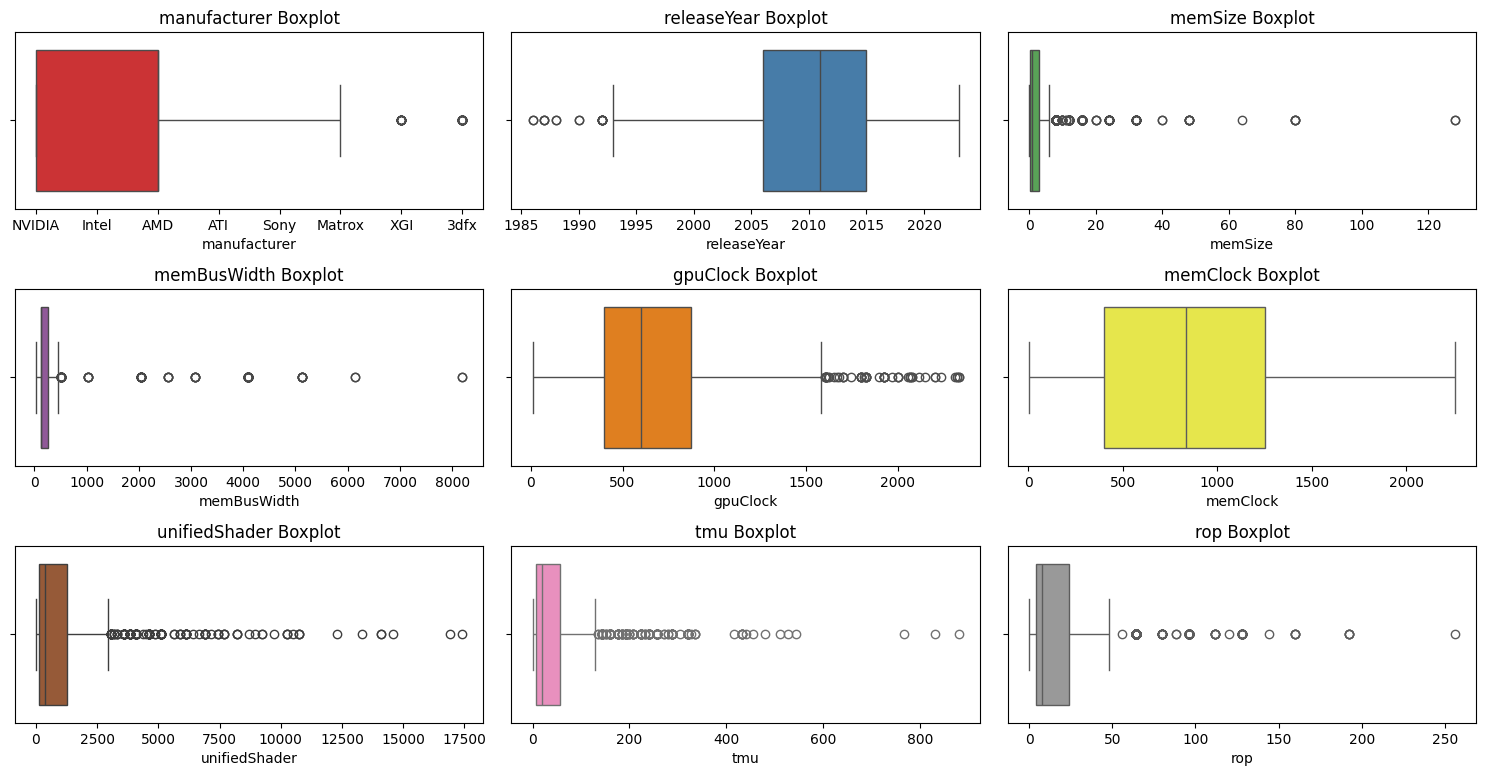

In [46]:
col_box = ['manufacturer', 'releaseYear', 'memSize', 'memBusWidth', 'gpuClock', 'memClock', 'unifiedShader', 'tmu', 'rop']
color_palette = sns.color_palette("Set1", len(col_box))

plt.figure(figsize=(15, 10))
for i, column in enumerate(col_box, 1):
    plt.subplot((len(col_box)//3)+1, 3, i)
    sns.boxplot(data=data, x=column, color=color_palette[i - 1])
    plt.xlabel(column)
    plt.title(f'{column} Boxplot')
plt.tight_layout()
plt.show()

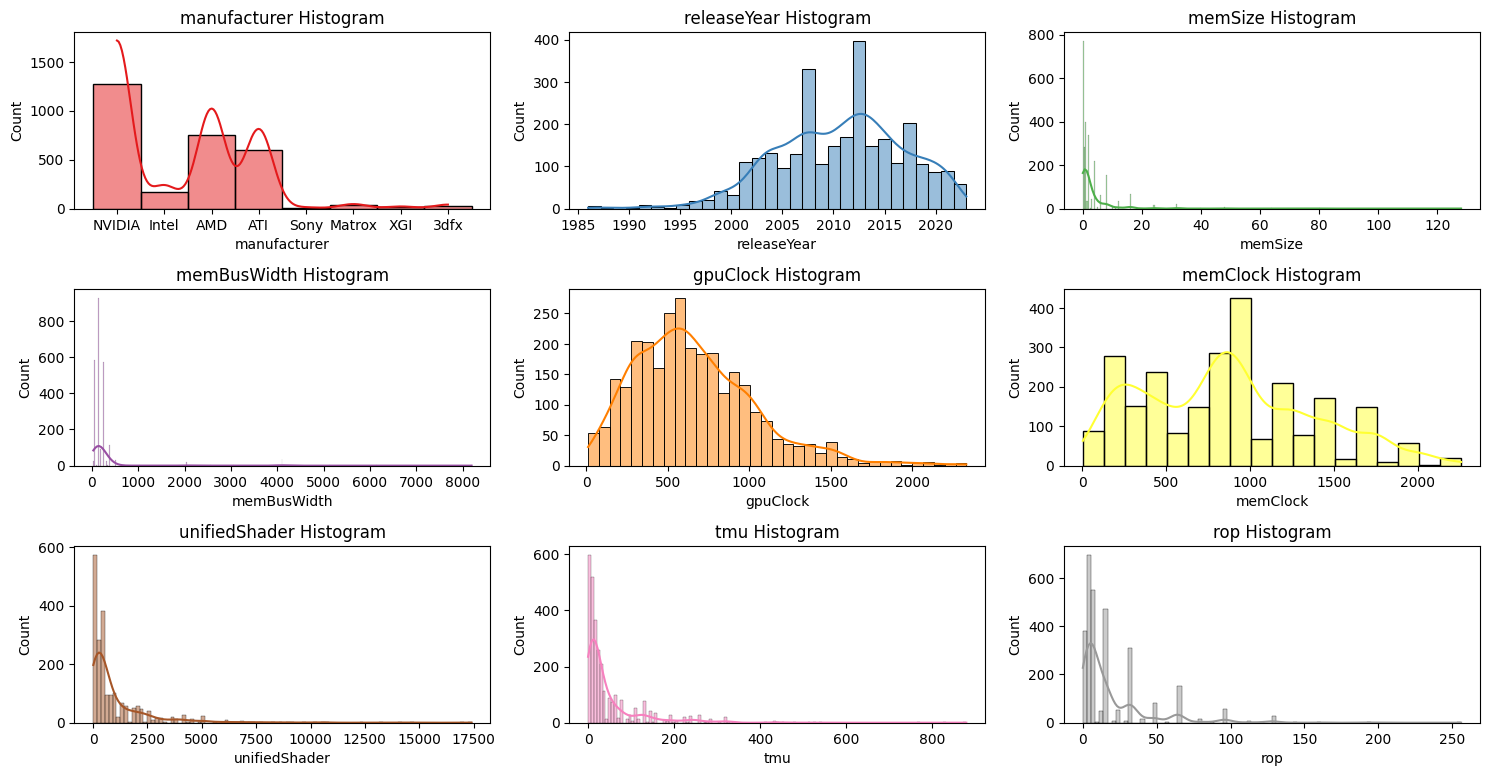

In [47]:
col_box = ['manufacturer', 'releaseYear', 'memSize', 'memBusWidth', 'gpuClock', 'memClock', 'unifiedShader', 'tmu', 'rop']
color_palette = sns.color_palette("Set1", len(col_box))

plt.figure(figsize=(15, 10))
for i, column in enumerate(col_box, 1):
    plt.subplot((len(col_box)//3)+1, 3, i)
    sns.histplot(data=data, x=column, color=color_palette[i - 1], kde=True)
    plt.xlabel(column)
    plt.title(f'{column} Histogram')
plt.tight_layout()
plt.show()

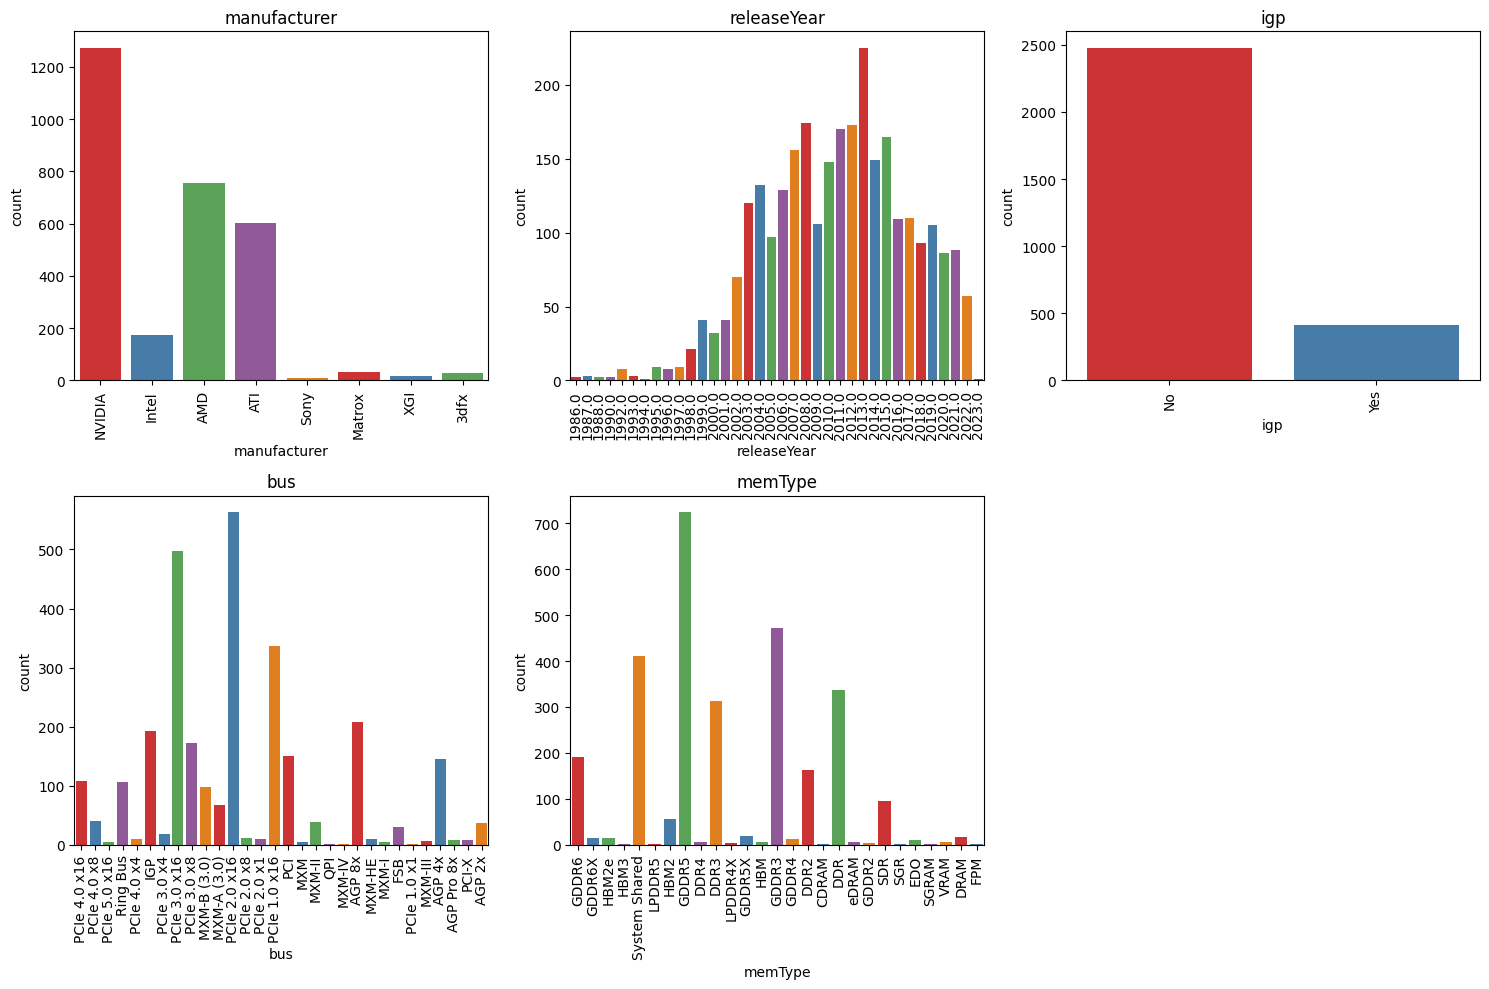

In [48]:
col_bar = ['manufacturer', 'releaseYear', 'igp', 'bus', 'memType']
color_palette = sns.color_palette("Set1", len(col_bar))

plt.figure(figsize=(15, 10))
for i, column in enumerate(col_bar, 1):
    plt.subplot((len(col_bar)//3)+1, 3, i)
    sns.countplot(data=data, x=column, palette=color_palette)
    plt.title(column)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

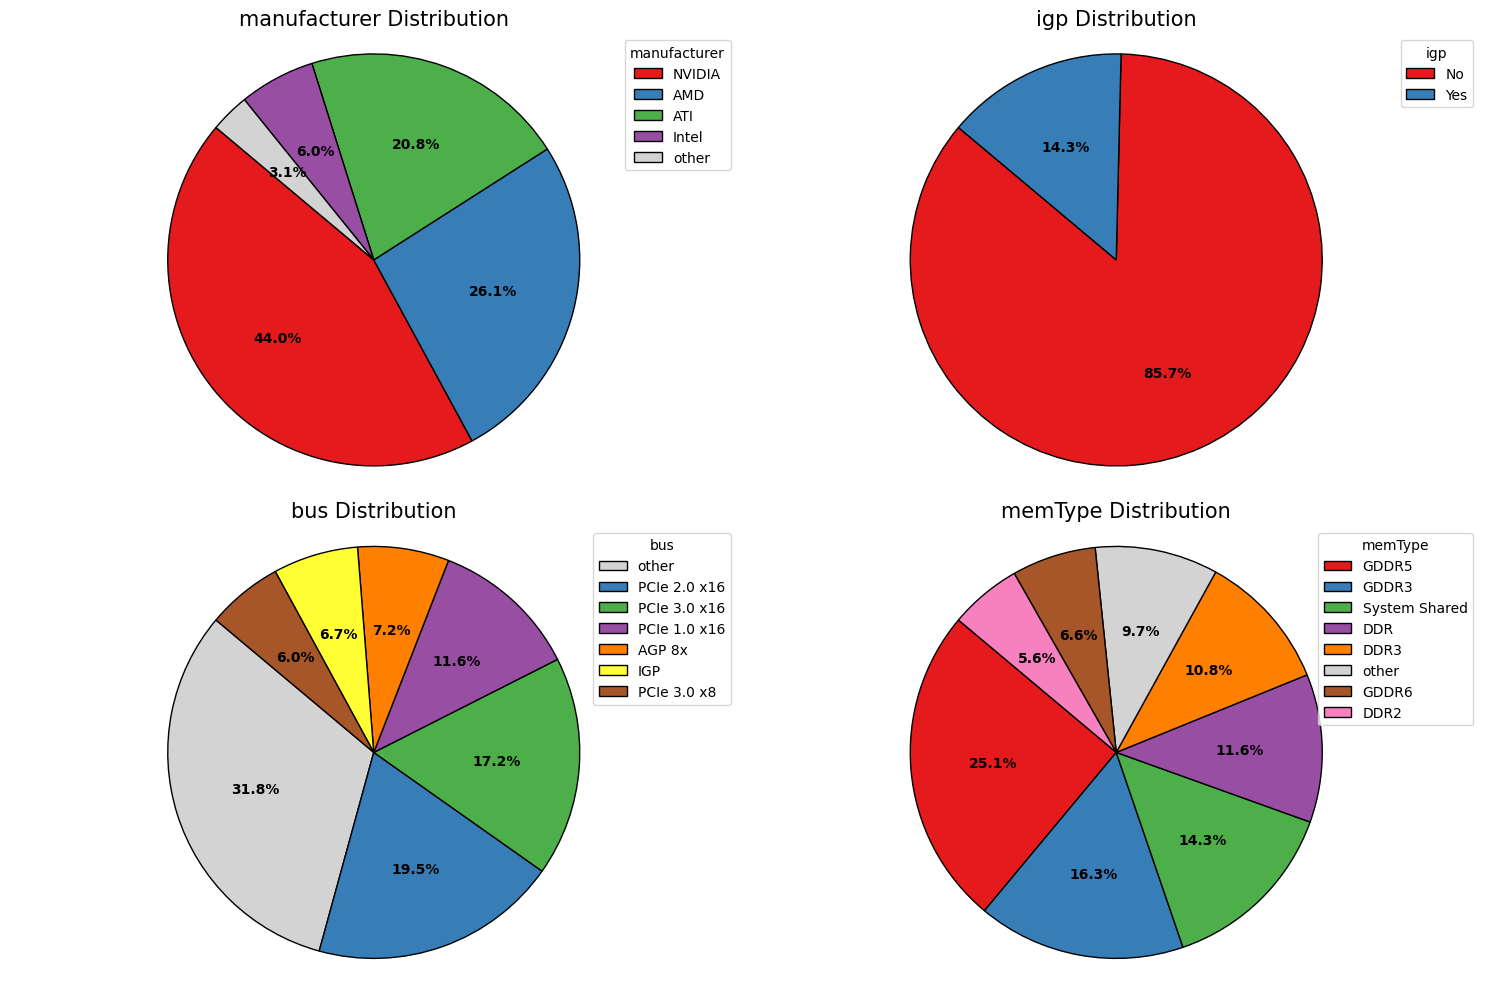

In [49]:
col_pie = ['manufacturer', 'igp', 'bus', 'memType']
df_pie = data[col_pie].copy()

percentage_threshold = 5.5
total_rows = len(df_pie)

for col in col_pie:
    value_counts = df_pie[col].value_counts()
    df_pie[col] = df_pie[col].apply(lambda x: 'other' if (value_counts[x] / total_rows) * 100 < percentage_threshold else x)

color_palette = sns.color_palette("Set1", 20)

plt.figure(figsize=(15, 10))

for i in range(len(col_pie)):
    plt.subplot(2, 2, i + 1)
    var = df_pie[col_pie[i]].value_counts()

    colors = color_palette[:len(var)]
    if 'other' in var:
        other_index = var.index.get_loc('other')
        colors[other_index] = 'lightgray'

    wedges, texts, autotexts = plt.pie(var, labels=None, autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops={'linewidth': 1, 'edgecolor': 'black'})

    for text, autotext in zip(texts, autotexts):
        text.set(size=10, weight='bold')
        autotext.set(size=10, weight='bold')

    plt.axis('equal')
    plt.title(f'{col_pie[i]} Distribution', fontsize=15)
    plt.legend(wedges, var.index, title=f'{col_pie[i]}', loc='best')

plt.tight_layout()
plt.show()

In [80]:
# Function for log transformation of the column
def log_transform(data,col):
    for colname in col:
        if (data[colname] == 1.0).all():
            data[colname + '_log'] = np.log(data[colname]+1)
        else:
            data[colname + '_log'] = np.log(data[colname])
    data.info()
    return data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2889 entries, 0 to 2888
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   releaseYear    2889 non-null   float64
 1   memSize        2889 non-null   float64
 2   memBusWidth    2889 non-null   float64
 3   gpuClock       2889 non-null   int64  
 4   memClock       2889 non-null   float64
 5   unifiedShader  2889 non-null   float64
 6   tmu            2889 non-null   int64  
 7   rop            2889 non-null   int64  
 8   pixelShader    2889 non-null   float64
 9   vertexShader   2889 non-null   float64
 10  gpuClock_log   2889 non-null   float64
 11  memClock_log   2889 non-null   float64
 12  tmu_log        2889 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 293.5 KB


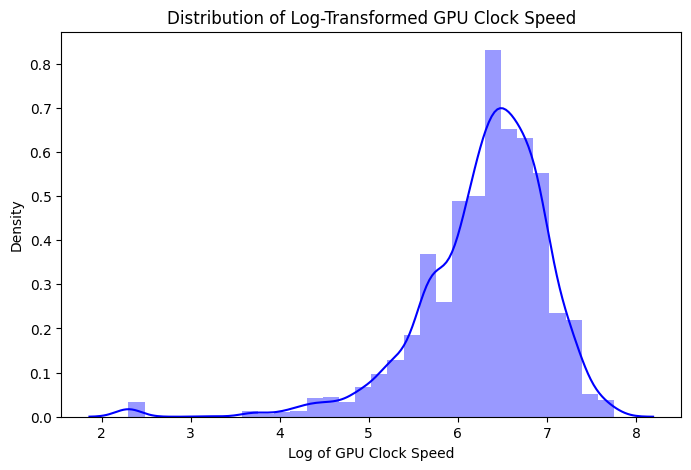

In [83]:
log_columns = ['gpuClock', 'memClock', 'tmu']
df_log_transformed = log_transform(df_numeric, log_columns)

# Plotting the distribution of one of the log-transformed features
plt.figure(figsize=(8, 5))
sns.distplot(df_log_transformed['gpuClock_log'], kde=True, color='blue', bins=30)
plt.xlabel("Log of GPU Clock Speed")
plt.title("Distribution of Log-Transformed GPU Clock Speed")
plt.show()

<Figure size 1300x1700 with 0 Axes>

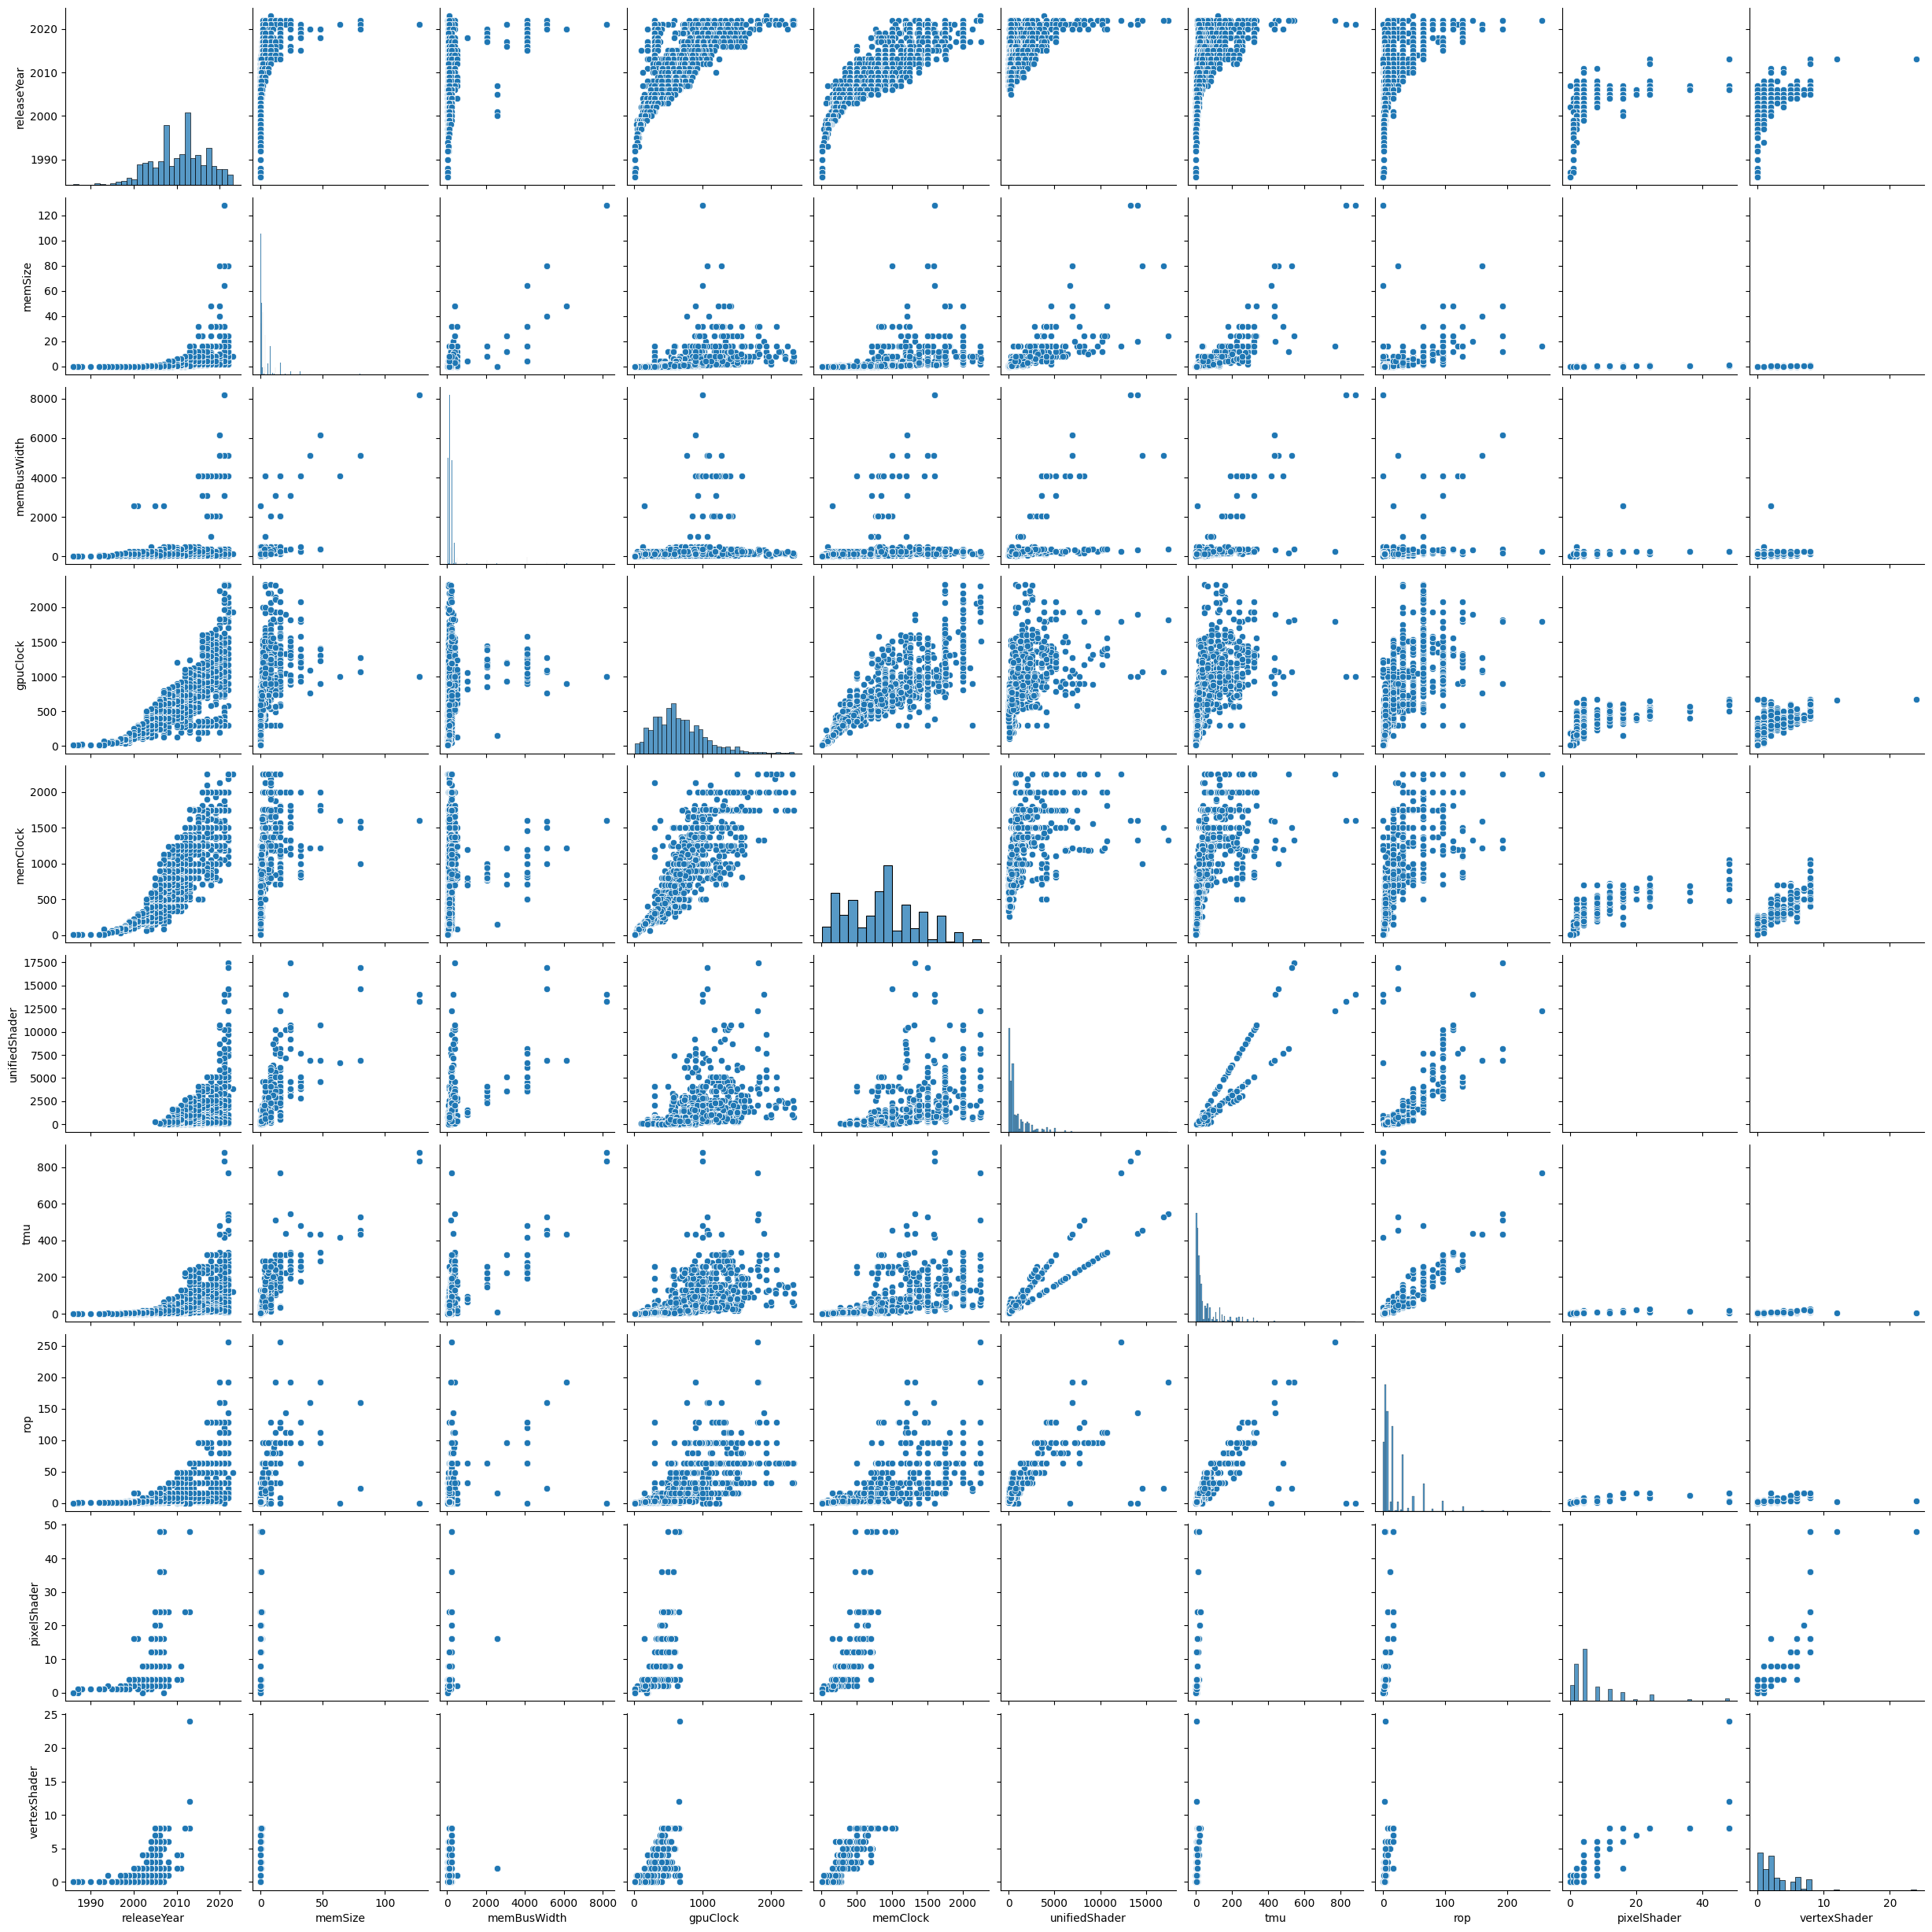

In [52]:
plt.figure(figsize=(13,17))
sns.pairplot(data.drop([col for col in cat_cols],axis=1))
plt.show()

<Axes: >

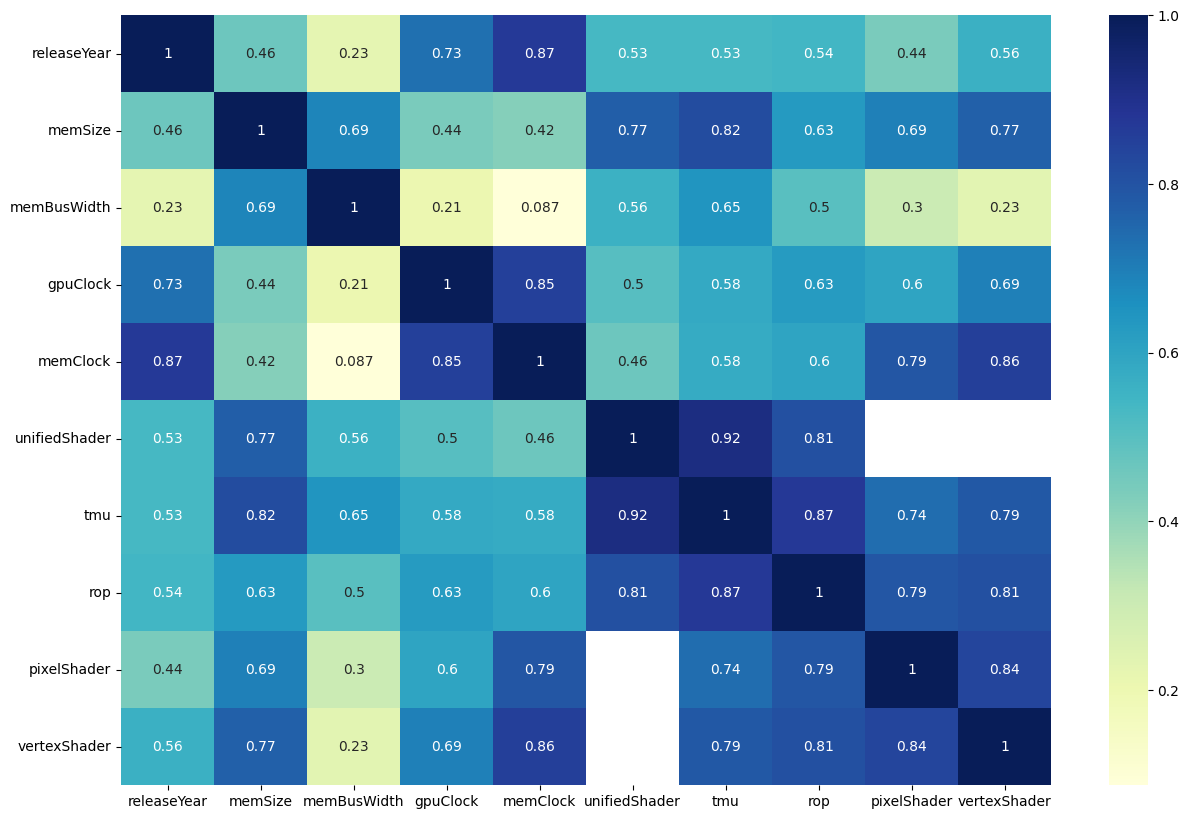

In [35]:
plt.figure(figsize=(15,10))
sns.heatmap(gpu_data.drop([col for col in cat_cols],axis=1).corr(), cmap="YlGnBu", annot=True)

In [60]:
numeric_cols = [
    'releaseYear', 'memSize', 'memBusWidth', 'gpuClock',
    'memClock', 'unifiedShader', 'tmu', 'rop',
    'pixelShader', 'vertexShader'
]

scaler = StandardScaler()
df_numeric = df[numeric_cols].fillna(df[numeric_cols].mean())
df_numeric_scaled = scaler.fit_transform(df_numeric)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_numeric_scaled)
pca_data = pd.DataFrame(pca_data, columns=["pc1", "pc2"])  # Menggunakan "pc1" dan "pc2" karena kita hanya memiliki 2 komponen
print("PCA explained variance ratio:\n", " ".join(map("{:.3f}".format, pca.explained_variance_ratio_)))

PCA explained variance ratio:
 0.498 0.195


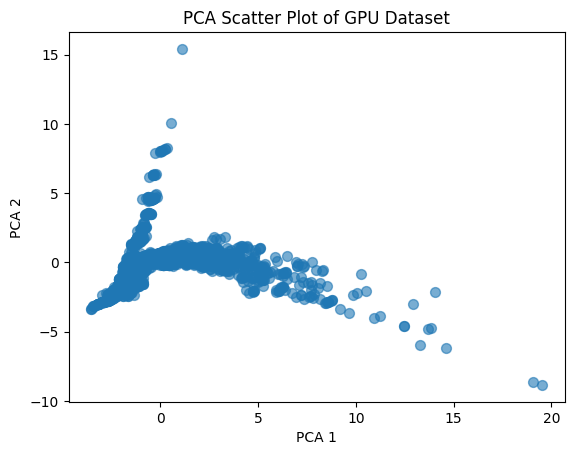

In [61]:
plt.scatter(pca_data["pc1"], pca_data["pc2"], s=50, alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA Scatter Plot of GPU Dataset')
plt.show()

In [62]:
pca_data = pca_data.values

In [63]:
wcss = []
scores = []
for i in range(2, 10):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    km.fit(pca_data)
    wcss.append(km.inertia_)

    labels = km.labels_
    silhouette_avg = silhouette_score(pca_data, labels)
    scores.append(silhouette_avg)
    print('wcss score for n_cluster = ' + str(i) + ' is ' + str(wcss))
    print('silhoutte score for n_clusters = ' + str(i) + ' is ' + str(silhouette_avg))

wcss score for n_cluster = 2 is [10931.611365189858]
silhoutte score for n_clusters = 2 is 0.6058201442069449
wcss score for n_cluster = 3 is [10931.611365189858, 7427.840317311428]
silhoutte score for n_clusters = 3 is 0.49487152546742624
wcss score for n_cluster = 4 is [10931.611365189858, 7427.840317311428, 5287.4765001011665]
silhoutte score for n_clusters = 4 is 0.5061613852679246
wcss score for n_cluster = 5 is [10931.611365189858, 7427.840317311428, 5287.4765001011665, 3690.0580931885456]
silhoutte score for n_clusters = 5 is 0.5449170861813575
wcss score for n_cluster = 6 is [10931.611365189858, 7427.840317311428, 5287.4765001011665, 3690.0580931885456, 2837.9606302514517]
silhoutte score for n_clusters = 6 is 0.5302778652890716
wcss score for n_cluster = 7 is [10931.611365189858, 7427.840317311428, 5287.4765001011665, 3690.0580931885456, 2837.9606302514517, 2304.3854796668434]
silhoutte score for n_clusters = 7 is 0.48986533381374076
wcss score for n_cluster = 8 is [10931.6113

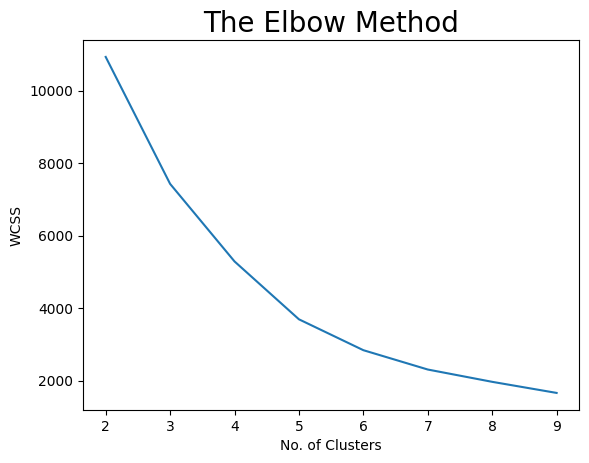

In [64]:
# Visualizing Elbow Method
plt.plot(range(2, 10), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS')
plt.show()

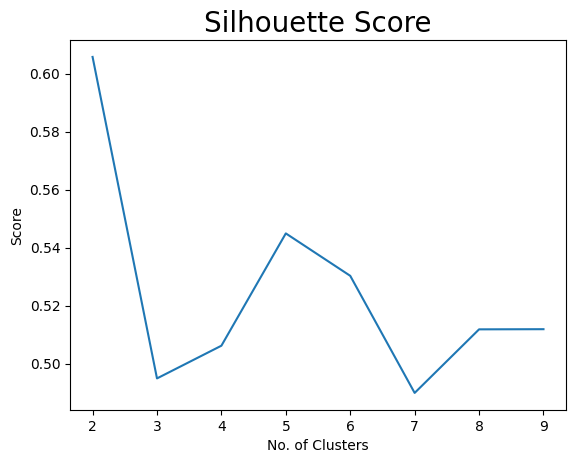

In [65]:
# Visualizing Silhouette Score
plt.plot(range(2, 10), scores)
plt.title('Silhouette Score', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('Score')
plt.show()

In [76]:
kmeansmodel = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
y_kmeans= kmeansmodel.fit_predict(pca_data)

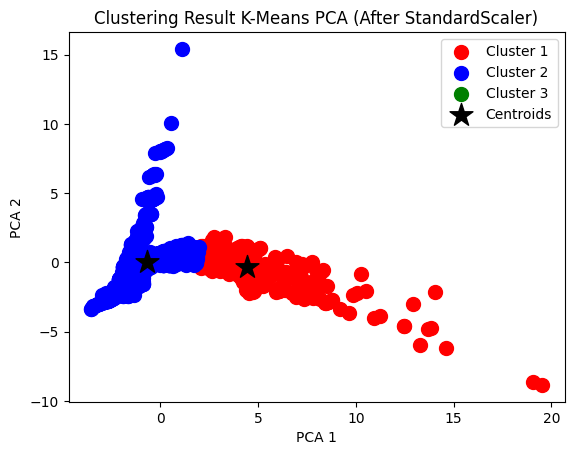

In [77]:
# Cluster visualization using scatter plot
plt.scatter(pca_data[y_kmeans == 0, 0], pca_data[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(pca_data[y_kmeans == 1, 0], pca_data[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(pca_data[y_kmeans == 2, 0], pca_data[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')

# Display the cluster center
plt.scatter(kmeansmodel.cluster_centers_[:, 0], kmeansmodel.cluster_centers_[:, 1], s = 300, c = 'black', label = 'Centroids', marker = '*')
plt.title('Clustering Result K-Means PCA (After StandardScaler)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

In [68]:
linkage_col = ['ward', 'complete', 'average', 'single']
scores_all = [[] for _ in range(len(linkage_col))]
for j in range (len(linkage_col)):
    print('Linkage: ', linkage_col[j])
    scores = []
    for i in range(2, 10):
        AC = AgglomerativeClustering(n_clusters=i, linkage = linkage_col[j]) # Menggunakan Ward Method
        AC.fit(pca_data)

        labels = AC.labels_
        silhouette_avg = silhouette_score(pca_data, labels)
        scores.append(silhouette_avg)
        print('silhoutte score for n_clusters = ' + str(i) + ' is ' + str(silhouette_avg))
    print("\n##########################\n")
    scores_all[j] = scores

Linkage:  ward
silhoutte score for n_clusters = 2 is 0.5143016005237644
silhoutte score for n_clusters = 3 is 0.4654780573457147
silhoutte score for n_clusters = 4 is 0.49842506372183054
silhoutte score for n_clusters = 5 is 0.5281103100670982
silhoutte score for n_clusters = 6 is 0.5290637474084604
silhoutte score for n_clusters = 7 is 0.4932216396677665
silhoutte score for n_clusters = 8 is 0.517809218321371
silhoutte score for n_clusters = 9 is 0.4988325776239587

##########################

Linkage:  complete
silhoutte score for n_clusters = 2 is 0.8143414602562203
silhoutte score for n_clusters = 3 is 0.6687979130650066
silhoutte score for n_clusters = 4 is 0.6519922567259787
silhoutte score for n_clusters = 5 is 0.4238804012748077
silhoutte score for n_clusters = 6 is 0.4224261889453569
silhoutte score for n_clusters = 7 is 0.42198213307975885
silhoutte score for n_clusters = 8 is 0.486349737520535
silhoutte score for n_clusters = 9 is 0.48025933593408904

#######################

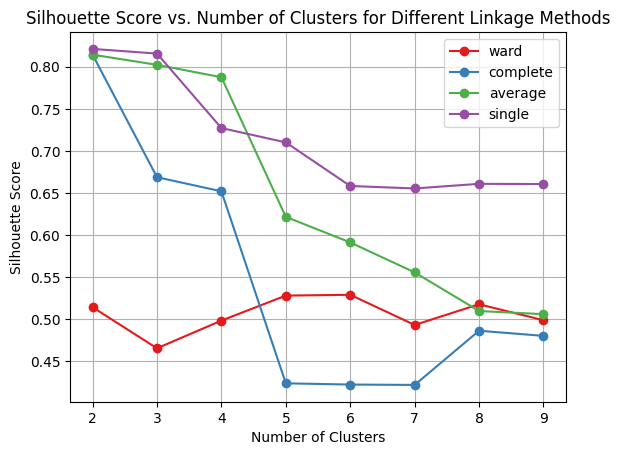

In [78]:
colors = sns.color_palette("Set1", len(linkage_col))

for j in range(len(linkage_col)):
    plt.plot(range(2, 10), scores_all[j], marker='o', color=colors[j], label=linkage_col[j])

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters for Different Linkage Methods')
plt.legend()
plt.grid(True)
plt.show()

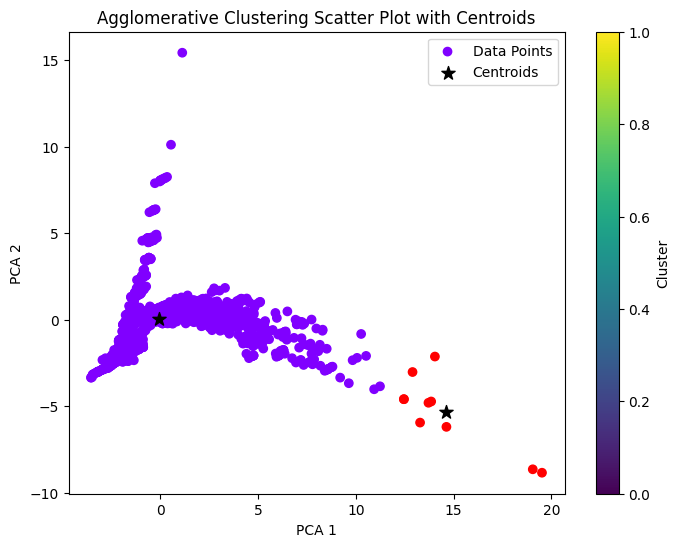

In [70]:
n_cluster = 2
AC = AgglomerativeClustering(n_clusters=n_cluster, linkage='complete')
labels = AC.fit_predict(pca_data)

df_train_with_labels = np.column_stack((pca_data, labels))

centroids = []
for cluster_label in range(n_cluster):
    cluster_data = df_train_with_labels[df_train_with_labels[:, -1] == cluster_label]
    cluster_centroid = np.mean(cluster_data[:, :-1], axis=0)
    centroids.append(cluster_centroid)

centroids = np.array(centroids)

plt.figure(figsize=(8, 6))

x = pca_data[:, 0]
y = pca_data[:, 1]

plt.scatter(x, y, c=labels, cmap='rainbow', label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='*', s=100, label='Centroids')

plt.title('Agglomerative Clustering Scatter Plot with Centroids')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

In [71]:
linked = sch.linkage(pca_data, 'complete')

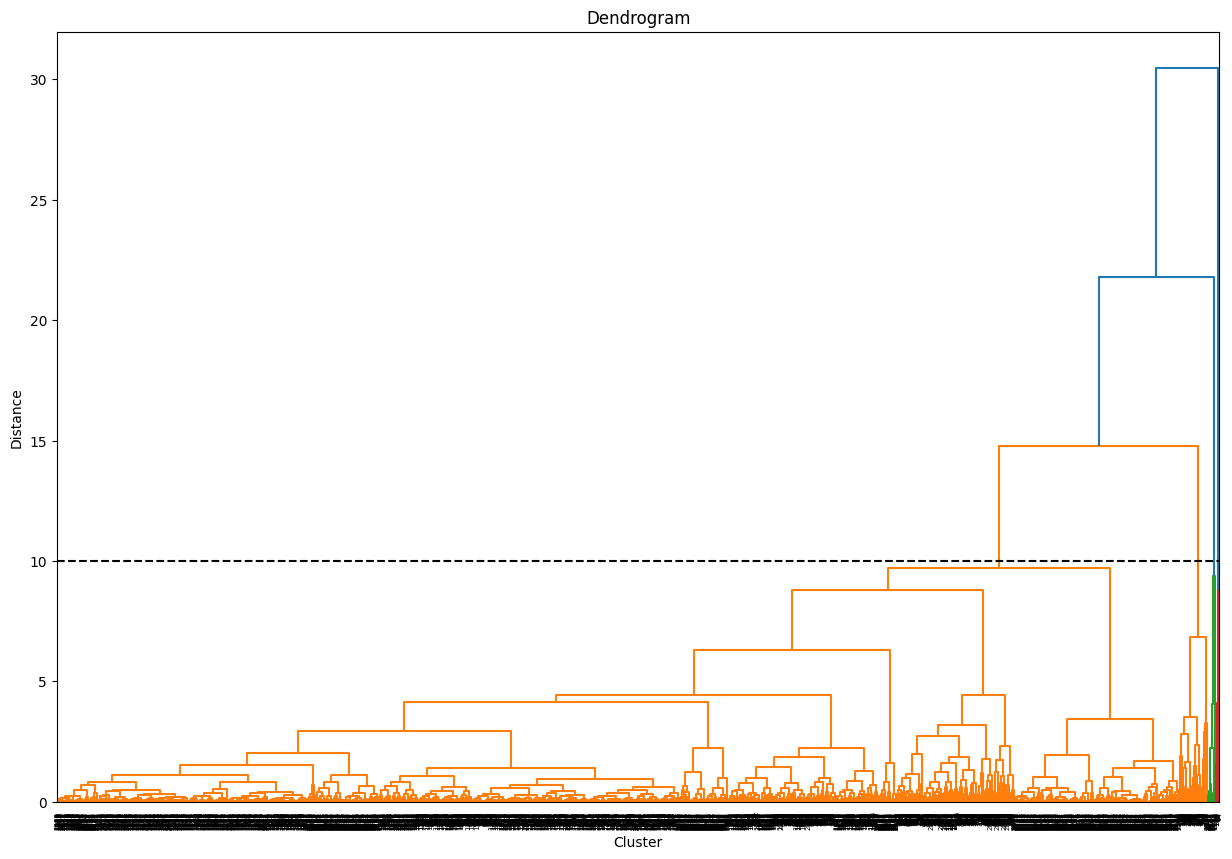

In [72]:
plt.figure(figsize=(15, 10))
dendrogram = sch.dendrogram(linked, orientation='top',distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Cluster')
plt.ylabel('Distance')
plt.axhline(y=10, color='black', linestyle='--') # at this point, will divide the data into 2 clusters
plt.show()

In [73]:
epsilon = [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
min_samples = [10, 15, 20, 25]

sil_avg = []
max_value = (0, 0, 0, -1)  # Initialize max_value with a negative silhouette score

for i in range(len(epsilon)):
    for j in range(len(min_samples)):
        db = DBSCAN(min_samples=min_samples[j], eps=epsilon[i]).fit(pca_data)

        # Check if there are at least two clusters
        unique_labels = set(db.labels_)
        if len(unique_labels) >= 2:
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)

            silhouette_avg = silhouette_score(pca_data, labels)
            sil_avg.append(silhouette_avg)

            if silhouette_avg > max_value[3]:
                max_value = (epsilon[i], min_samples[j], n_clusters_, silhouette_avg)

print("epsilon =", max_value[0],
      "\nmin_samples =", max_value[1],
      "\nnumber of clusters =", max_value[2],
      "\naverage silhouette score = %.4f" % max_value[3])

epsilon = 3 
min_samples = 10 
number of clusters = 1 
average silhouette score = 0.8529


In [74]:
db=DBSCAN(eps=3, min_samples=10, metric='euclidean')
db.fit(pca_data)

DBSCAN(eps=3, min_samples=10)

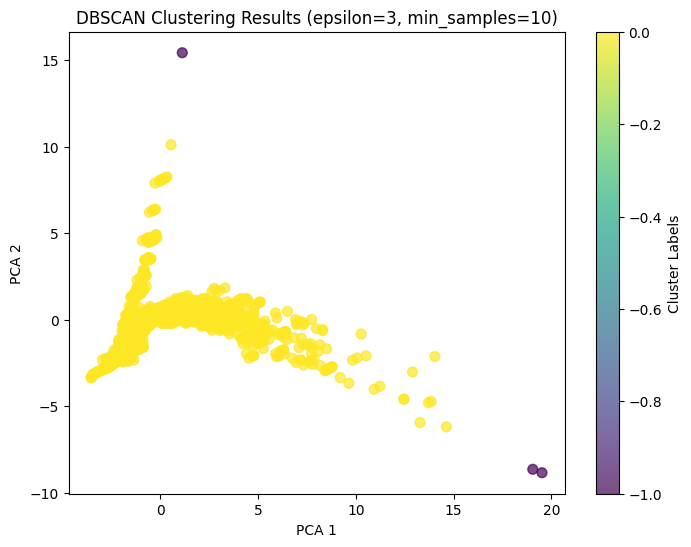

In [75]:
best_epsilon = max_value[0]
best_min_samples = max_value[1]
best_labels = db.labels_

plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=best_labels, cmap='viridis', s=50, alpha=0.7)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('DBSCAN Clustering Results (epsilon={}, min_samples={})'.format(best_epsilon, best_min_samples))

plt.colorbar(label='Cluster Labels')
plt.show()